### Small comment

I guess I want to make a small comment before you start
looking through this code.

Most of my time just went into reading the background material 
on QAOA, as I have never seen it before.
After a while of search I stumbled onto Ruslan Shaydulin's 
video on youtube and his code in github repo:
https://github.com/rsln-s/IEEE_QW_2020
Amazing video on QAOA, probably best explanation I have seen.
So I wanted to give him props when they are due :)

His code and explanation is mostly on unweighted graph for maxcut,
which is very similar to the link provided for the cirq
explanation, but his is in qiskit, which I happen to be 
more familiar with.

Basically, all I did was modifying his code slightly.
Well in nutshell all needed to be done was to add
weight phase to the cost Hamiltonian... 

There are parts of the code I don't have much of intuition,
but overall I think I understand. Most of my
studying can be found in the pdf


In [129]:
# import libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister
from qiskit import ClassicalRegister, execute, Aer
from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import op_converter
from qiskit.aqua.operators import WeightedPauliOperator

from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

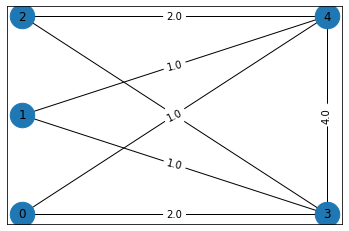

In [130]:
# let's create a graph with weighted edges?
# My guess that is the objective... let's see
# if it works
G = nx.Graph()
n = 5
V = np.arange(0, n, 1)
E = [(3,4,4.0),(0,3,2.0),(0,4,1.0),(1,3,1.0),(1,4,1.0),(2,3,1.0),(2,4,2.0)]
G.add_weighted_edges_from(E)
default_axes = plt.axes(frameon=True)
colors = ['r' for node in G.nodes()]
pos = nx.bipartite_layout(G, [0,1,2])
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
nx.draw_networkx(G, node_size = 600, alpha=1, pos=nx.bipartite_layout(G, [0,1,2]))

In [131]:
# I am not sure here, but we need Hc and Hb
# where Hc is a cost Hamiltonian
# where Hb is a mixer Hamiltonian

# Hc
def append_zz_term(qc, q1, q2, gamma, w):
    # I kinda understand that we need to add
    # weight phase here
    # cause Hc = w*(1-ZZ)
    qc.cx(q1, q2)
    qc.rz(w*gamma, q2)
    qc.cx(q1, q2)
    
def get_cost_operator_circuit(G, gamma):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N, N)
    for i, j in G.edges():
        append_zz_term(qc, i, j, gamma, G[i][j]['weight'])
        qc.barrier()
    return qc

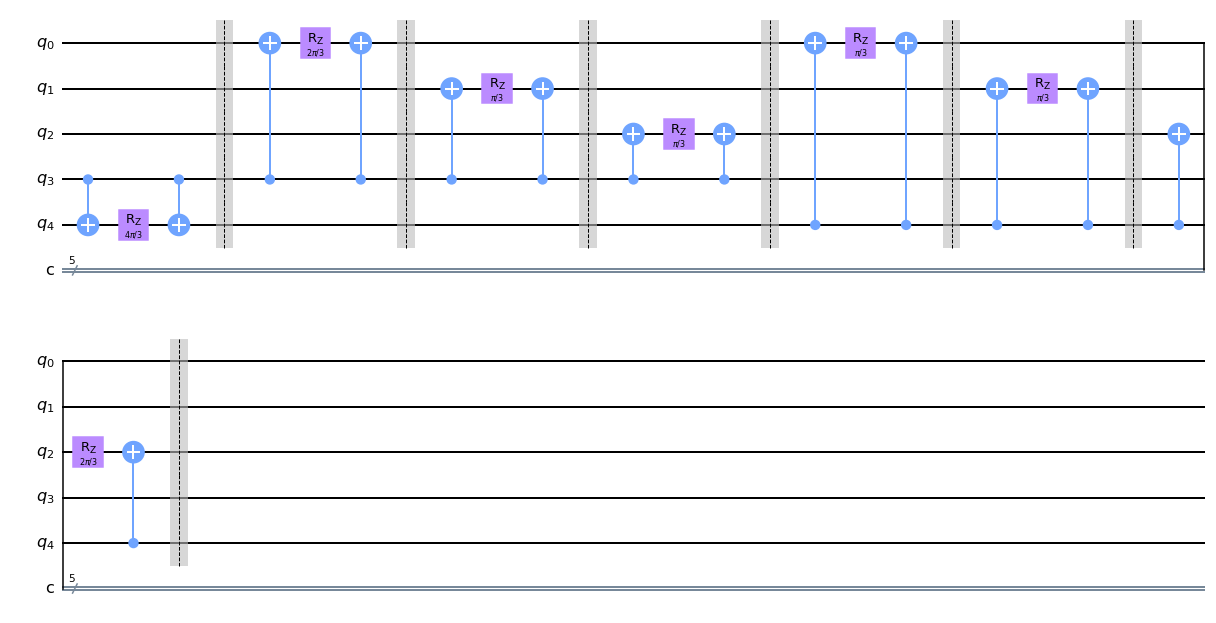

In [132]:
# check Cost circuit is correct
qc = get_cost_operator_circuit(G, np.pi/3)
qc.draw('mpl')

In [133]:
# Now mixer Hamiltonian
def append_x_term(qc, q1, beta):
    qc.rx(2*beta, q1)
    
def get_mixer_operator_circuit(G, beta):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N, N)
    
    for n in G.nodes():
        append_x_term(qc, n, beta)
    return qc

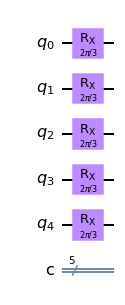

In [134]:
# check if mixer circuit works
qc = get_mixer_operator_circuit(G, np.pi/3)
qc.draw('mpl')

In [135]:
# okay now we just need to combine everything?

def get_qaoa_circuit(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta)
    N = G.number_of_nodes()
    qc = QuantumCircuit(N, N)
    qc.h(range(N))
    
    for i in range(p):
        qc += get_cost_operator_circuit(G, gamma[i])
        qc += get_mixer_operator_circuit(G, beta[i])
    
    qc.barrier(range(N))
    qc.measure(range(N), range(N))
    return qc

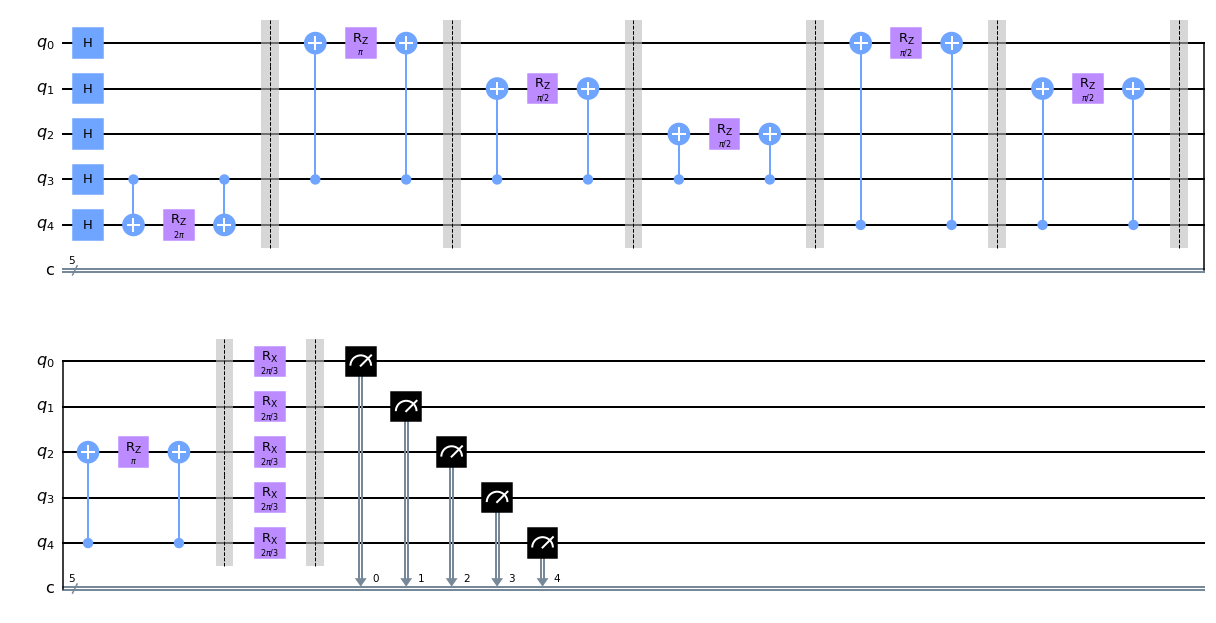

In [136]:
# check if combined circuit works
qc = get_qaoa_circuit(G, [np.pi/3], [np.pi/2])
qc.draw('mpl')


In [137]:
# to invert results
def invert_counts(counts):
    # invert k for every v
    return {k[::-1]:v for k, v in counts.items() }


{'00000': 41, '10000': 47, '00001': 38, '10001': 64, '01001': 15, '11001': 57, '00101': 13, '10101': 15, '01101': 14, '11101': 36, '00011': 19, '10011': 2, '11011': 49, '00111': 6, '10111': 92, '01111': 38, '11111': 39, '01000': 102, '11000': 2, '00100': 38, '10100': 1, '01100': 7, '11100': 24, '00010': 39, '10010': 8, '01010': 12, '11010': 11, '00110': 75, '10110': 11, '01110': 68, '11110': 41}


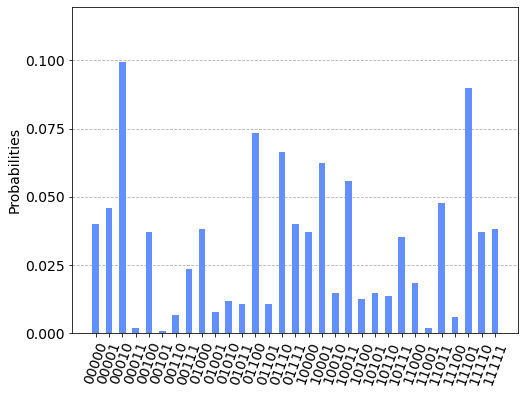

In [138]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend)
result = job.result()
print(invert_counts(result.get_counts()))
plot_histogram(result.get_counts(), figsize = (8, 6), bar_labels = False)

# okay but so far it looks quite random
# how do we actually find the solution here?

In [139]:
# we define cut function?
def maxcut_obj(x, G):
    # x is a bitstring, so if they aren't equal 
    # we need to add the weight of the edge
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            #print("{} {} {}".format(i, j, G[i][j]['weight']))
            cut -= G[i][j]['weight']
    return cut

maxcut_obj('11001',G)

-9.0

In [140]:
# Compute energy?
def compute_maxcut_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = maxcut_obj(meas, G)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts

compute_maxcut_energy(invert_counts(result.get_counts()), G)


-5.5595703125

In [141]:
# Now finally implement classical optimizer!
def get_black_box_objective(G, p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit(G, beta, gamma)
        counts = execute(qc, backend).result().get_counts()
        return compute_maxcut_energy(invert_counts(counts), G)
    # still no idea how this works
    # passing no parameters to f is op
    return f

In [143]:
# okay let's try
p = 5
obj = get_black_box_objective(G, p)

#random init point
init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])

res_sample = minimize(obj, init_point, method = 'COBYLA', options = {'maxiter':2500, 'disp':True})
res_sample

     fun: -8.6826171875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 116
  status: 1
 success: True
       x: array([0.62269935, 2.27135753, 1.03386259, 3.17126904, 0.2895348 ,
       2.25142695, 7.1952062 , 2.14522543, 3.85776548, 6.20551868])

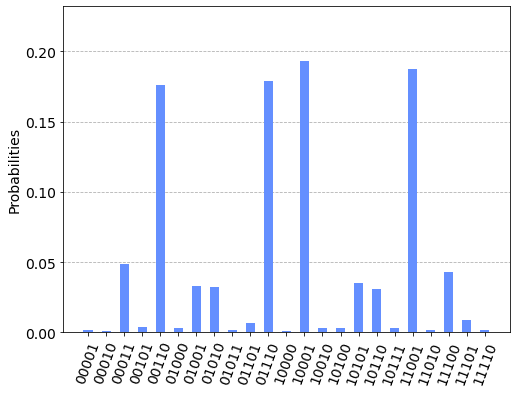

In [144]:
# okay now that we were able to ...
optimal_theta = res_sample['x']
qc = get_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
counts = invert_counts(execute(qc, backend).result().get_counts())
counts
plot_histogram(counts, figsize = (8, 6), bar_labels = False)


<BarContainer object of 6 artists>

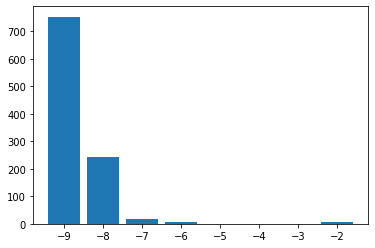

In [145]:
energies = defaultdict(int)
for k, v in counts.items():
    energies[maxcut_obj(k, G)] += v
    
x, y = zip(*energies.items())
plt.bar(x,y)

Best string: 10001 with cut: 9.0


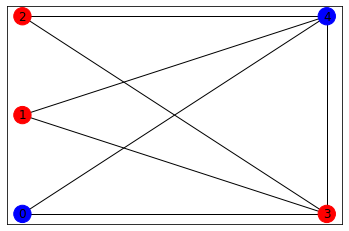

In [146]:
# draw best solution?
best_cut, best_solution = min([(maxcut_obj(x, G), x) for x in counts.keys()], key = itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")
colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw_networkx(G, node_color = colors, pos = nx.bipartite_layout(G, [0,1,2]))